In [1]:
from google.colab import drive
from PIL import Image
import os
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Layer, UpSampling2D, Activation, Input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from keras import backend as K
from keras import losses
from keras import optimizers
import tensorflow as tf

Using TensorFlow backend.


In [0]:
drive.mount('/content/gdrive')

In [0]:
!tar xvf "../content/gdrive/My Drive/glimpse_dataset/coco.tar"

In [0]:
def dataset_generator(batch_size):
  heatmaps_names = os.listdir("coco/heatmaps/")
  resize_240 = transforms.Resize(240)
  resize_30 = transforms.Resize(30)
  
  last_index = 0
  
  while True:
    heatmaps = []
    images = []
  
    for heatmap_name in heatmaps_names[last_index:last_index+batch_size]:
      heatmap = Image.open("coco/heatmaps/" + heatmap_name)
      heatmap = resize_30(heatmap)
      heatmaps.append(img_to_array(heatmap) / 255)

      image = Image.open("coco/images/" + heatmap_name).convert('RGB')   
      image = resize_240(image)
      images.append(img_to_array(image) / 255)

    last_index += batch_size 
    
    if last_index >= len(heatmaps_names):
      last_index = 0
      
    yield np.array(images), np.array(heatmaps)

In [5]:
images, heatmaps = next(iter(dataset_generator(8)))
images.shape, heatmaps.shape

((8, 240, 320, 3), (8, 30, 40, 1))

In [0]:
def residual_block(output, filters):
  out = output
  
  output = Conv2D(filters, kernel_size=3, padding='same', strides=1)(output)
  output = BatchNormalization()(output)
  output = Activation('relu')(output)

  output = Conv2D(filters, kernel_size=3, padding='same', strides=1)(output)
  output = BatchNormalization()(output)
  
  output = layers.add([out, output])

  return output

In [8]:
visible = Input(shape=(240, 320, 3))

output = Conv2D(8, kernel_size=9, padding='same', strides=4)(visible)
output = BatchNormalization()(output)
output = Activation('relu')(output)

output = Conv2D(16, kernel_size=3, padding='same', strides=2)(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)

output = Conv2D(32, kernel_size=3, padding='same', strides=2)(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)

output = residual_block(output, 32)
output = Conv2D(64, kernel_size=1, padding='same', strides=1, bias=False)(output)
output = residual_block(output, 64)

output = Conv2D(16, kernel_size=3, padding='same', strides=1)(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
  
output = UpSampling2D(2)(output)

output = Conv2D(1, kernel_size=9, activation='sigmoid', padding='same')(output)

model = Model(inputs=visible, outputs=output)
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='mse', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, kernel_size=1, padding="same", strides=1, use_bias=False)`
  app.launch_new_instance()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 60, 80, 8)    1952        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 60, 80, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 60, 80, 8)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [9]:
report = model.fit_generator(dataset_generator(8), steps_per_epoch=1875, epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1875/1875 [==============================] - 250s 133ms/step - loss: 0.0150 - acc: 0.0667
Epoch 2/5
1875/1875 [==============================] - 246s 131ms/step - loss: 0.0124 - acc: 0.0668
Epoch 3/5
1875/1875 [==============================] - 245s 130ms/step - loss: 0.0116 - acc: 0.0668
Epoch 4/5
1875/1875 [==============================] - 243s 130ms/step - loss: 0.0111 - acc: 0.0668
Epoch 5/5
1875/1875 [==============================] - 243s 130ms/step - loss: 0.0108 - acc: 0.0668


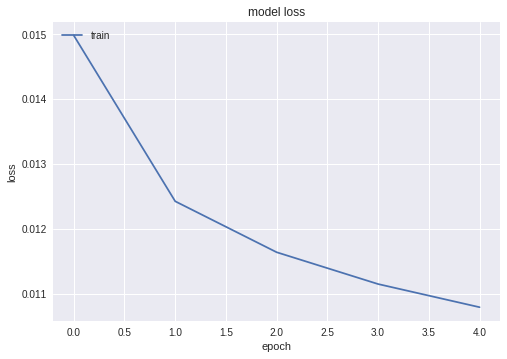

In [10]:
plt.plot(report.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
data_gen = dataset_generator(1)

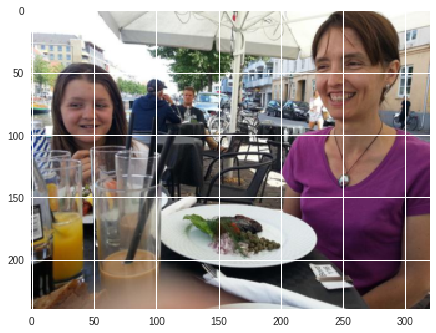

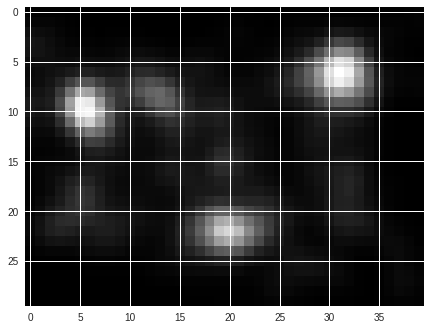

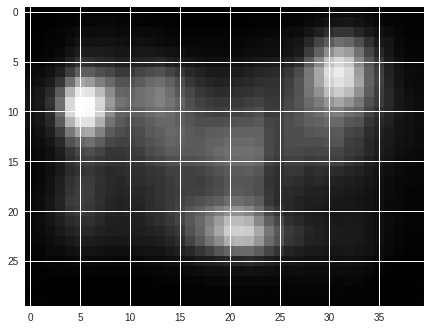

In [14]:
images, heatmaps = next(iter(data_gen))


plt.imshow(images[0])
plt.show()

true = K.softmax(heatmaps[0].reshape(-1))
true = K.eval(true).reshape(30,40) 
plt.imshow(true, cmap='Greys_r')
plt.show()

output = K.softmax(model.predict(images)[0].reshape(-1))
output = K.eval(output).reshape(30,40) 
plt.imshow(output, cmap='Greys_r')
plt.show()

In [0]:
model.save('gdrive/My Drive/k_saliency_model.h5') 